# Week 4 - Word Embeddings

This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them. Documents here are represented as densely indexed locations in dimensions, rather than sparse mixtures of topics (as in LDA topic modeling), so that distances between those documents (and words) are consistently superior, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

For this notebook we will be using the following packages

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#gensim uses a couple of deprecated features
#we can't do anything about them so lets ignore them 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

# Getting our corpora

Instead of downloading our corpora, we have download them in advance; a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `grimmerPressReleases`. We will load them into a DataFrame, using a function from a couple weeks ago `loadTextDirectory`:

In [2]:
kennedyDF = lucem_illud.loadTextDirectory('../data/grimmerPressReleases/Kennedy/')
kennedyDF[:5]

,text
01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...


This gets us one Senator's data, but with no metadata, we can add a category column with a simple command:

In [3]:
kennedyDF['category'] = 'Kennedy'
kennedyDF[:5]

,text,category
01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


We also will be wanting to load all the senators so we will need to loop over all the directories

In [4]:
dataDir = '../data/grimmerPressReleases'

senReleasesDF = pandas.DataFrame()

for senatorDir in (file for file in os.scandir(dataDir) if not file.name.startswith('.') and file.is_dir()):
    senDF = lucem_illud.loadTextDirectory(senatorDir.path)
    senDF['category'] = senatorDir.name
    senReleasesDF = senReleasesDF.append(senDF, ignore_index = False)

senReleasesDF[:5]

,text,category
01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


We also want to remove stop words and stem. Tokenizing requires two steps. Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone. As such, tokenizing is slightly more involved, but we can still use `lucem_illud`.

In [5]:
#Apply our functions, notice each row is a list of lists now
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

senReleasesDF[:5]

,text,category,tokenized_sents,normalized_sents
01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."
01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."
01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, wash..."
01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, wash..."
01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."


# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data, we give all the sentences to the trainer. We just need to add the words as a list of sentences:

In [6]:
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum())

Inside the word2vec object, the words each have a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [7]:
print("A {} dimesional vector:".format(senReleasesW2V['president'].shape[0]))
senReleasesW2V['president']

A 100 dimesional vector:


array([-1.0307747 ,  0.19203079, -2.9811432 ,  0.41072562, -0.36869532,
       -1.9266837 ,  1.8121969 , -0.68619525, -1.6395568 , -0.30785838,
       -1.5774987 ,  0.2514106 , -1.3732842 , -2.0825636 , -0.4678449 ,
       -0.79892915,  1.2683582 ,  2.109924  , -4.702559  ,  2.3359563 ,
       -0.7882934 , -2.2140822 ,  0.35168615, -0.8085008 , -1.1504772 ,
        0.33345807,  2.278303  ,  0.66080964,  0.637943  , -2.7673912 ,
       -0.16930571,  0.06341994, -2.0762916 , -1.3033403 ,  0.49128917,
        2.087261  , -1.8639416 , -0.9590534 , -1.158412  , -1.6931905 ,
        2.0722303 , -0.9680492 ,  1.6097457 ,  0.6217827 ,  0.21432728,
       -1.2216704 , -0.87922496,  0.815528  , -1.6276689 , -0.10115107,
       -0.62926435,  0.5265604 ,  1.0033196 ,  0.27837965,  1.3964914 ,
        2.4603517 , -0.4364217 , -0.8718042 ,  0.88997227, -1.2472919 ,
        3.698714  , -0.8310683 ,  1.748932  ,  0.8471218 , -0.59992445,
        1.9269228 ,  0.16084734, -0.68480074, -1.757404  , -0.47

If you want the full matrix, `syn0` stores all the vectors:

In [8]:
senReleasesW2V.wv.syn0

array([[-0.10733043,  0.15208355,  0.07794376, ...,  1.236433  ,
         1.1696931 ,  2.044862  ],
       [ 0.35812616, -2.0032613 ,  1.6895179 , ..., -0.30198985,
        -0.01599635,  0.6155914 ],
       [ 2.1398659 , -1.4266974 , -1.5268192 , ...,  1.069906  ,
        -0.2924204 , -0.07309374],
       ...,
       [-0.08008797, -0.00515069,  0.10957953, ..., -0.06335114,
         0.07408802,  0.02865674],
       [ 0.01271507, -0.01102411, -0.01242754, ..., -0.0362124 ,
         0.00681745,  0.01055784],
       [-0.0660001 ,  0.06555326,  0.1036745 , ..., -0.08741931,
         0.12089466,  0.06775483]], dtype=float32)

Then, `index2word` lets you translate from the matrix to words

In [9]:
senReleasesW2V.wv.index2word[10]

'american'

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [10]:
senReleasesW2V.most_similar('president')

[('administration', 0.7793764472007751),
 ('presidents', 0.748950719833374),
 ('administrations', 0.686938464641571),
 ('george', 0.6176577210426331),
 ('cheney', 0.595413327217102),
 ('responds', 0.5513138771057129),
 ('rollback', 0.5434801578521729),
 ('gimmicks', 0.5388391017913818),
 ('lamont', 0.5326244235038757),
 ('sticklers', 0.5216896533966064)]

In [11]:
senReleasesW2V.most_similar('war')

[('quagmire', 0.6405020952224731),
 ('foment', 0.6401472091674805),
 ('afghanistan', 0.6399059295654297),
 ('wars', 0.6337176561355591),
 ('disobedience', 0.6311540603637695),
 ('militarily', 0.6047148704528809),
 ('unresisted', 0.5999585390090942),
 ('chaos', 0.5957682132720947),
 ('descending', 0.5924106240272522),
 ('battle', 0.5864602327346802)]

Or we can get this directly (calculated slightly differently):

In [14]:
def cos_difference(embedding,word1,word2):
    return sklearn.metrics.pairwise.cosine_similarity(embedding[word1].reshape(1,-1),embedding[word2].reshape(1,-1))

In [13]:
cos_difference(senReleasesW2V, 'war', 'unwinnable')

array([[0.4596965]], dtype=float32)

We can also find which word least matches the others within a word set (cosine similarity):

In [14]:
senReleasesW2V.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

'washington'

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [15]:
senReleasesW2V.most_similar(positive=['clinton', 'republican'], negative = ['democrat'])

[('bush', 0.7304625511169434),
 ('veto', 0.7050485610961914),
 ('bushs', 0.7034592628479004),
 ('vetoed', 0.6977795362472534),
 ('signing', 0.6736279726028442),
 ('signature', 0.6579673886299133),
 ('blocked', 0.6453791856765747),
 ('proposing', 0.6316179633140564),
 ('musharraf', 0.6286833882331848),
 ('vetoes', 0.6249666213989258)]

Here we see that **Clinton + Republican - Democrat = Bush**. In other words, in this dataset and period, **Clinton** was to **Democrat** as **Bush** was to **Republican**. Whoah!

 But how do we argue that these are stable distances or associations?

## Establishing Credible or Confidence Intervals

### Boostrapping approach

We propose well-established bootstrapping and subsampling methods to nonparametrically demonstrate the stability and significance of word associations within our embedding model. These allow us to establish conservative confidence intervals to both (a) distances between words in a model and (b) projections of words onto an induced dimension (e.g., man-woman). If we assume that the texts (e.g., newspapers, books) underlying our word embedding model are observations drawn from an independent and identically distributed (i.i.d.) population of cultural observations, then bootstrapping allows us to estimate the variance of word distances and projections by measuring those properties through sampling the empirical distribution of texts with replacement (Efron and Tibshirani 1994; Efron 2003). Operationally, if we wanted to bootstrap a 90% confidence interval of a word-word distance or word-dimension projection, we would sample a corpus the same size as the original corpus, but with replacement, 20 times, estimate word embedding models on each sample. Then we take the 2nd order (2nd smallest) statistic $s_{(2)}$--either distance or projection--as our confidence interval’s lower bound, and 19th order statistic $s_{(19)}$ as its upper bound. The distance between $s_{(2)}$ and $s_{(19)}$ across 20 bootstrap samples span the 5th to the 95th percentiles of the statistic’s variance, bounding the 90th confidence interval. A 95% confidence interval would span $s_{(2)}$ and $s_{(39)}$ in word embedding distances or projections estimated on 40 bootstrap samples of a corpus, tracing the 2.5th to 97.5th percentiles. 

In [16]:
estimatesB=[]
for x in range(20):
    senReleasesW2VB = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sample(frac=1.0, replace=True).sum())
    try:
        estimatesB.append(cos_difference(senReleasesW2VB, 'war', 'unwinnable')[0,0])
    except KeyError:
        #Missing one of the words from the vocab
        pass
                                                      
estimatesB.sort()         
estimatesB

[0.31321144,
 0.33652437,
 0.34983534,
 0.3574487,
 0.3642871,
 0.3795838,
 0.39344049,
 0.4008341,
 0.401982,
 0.40456232,
 0.41807282,
 0.46982285,
 0.46984938,
 0.50143766,
 0.53868777,
 0.5697503,
 0.5827737,
 0.5968215,
 0.6696576]

In [17]:
print("The 90% confidence interval for the cosine distance between war and unwinnable is:\n",estimatesB[1], estimatesB[-2])

The 90% confidence interval for the cosine distance between war and unwinnable is:
 0.33652437 0.5968215


### Subsampling approach

If the corpus is large, then we may take a subsampling approach, which randomly partitions the corpus into non-overlapping samples, then estimates the word-embedding models on these subsets and calculates confidence intervals as a function of the empirical distribution of distance or projection statistics and number of texts in the subsample (Politis and Romano 1997). Subsampling requires the same i.i.d. assumption as the bootrap (Politis and Romano 1992; Politis and Romano 1994). For 90% confidence intervals, we randomly partition the corpus into 20 subcorpora, then calculate $B^k=\sqrt{\tau_k}\left(s^k-\bar{s}\right)$ for each $k$th sample, where $k$ is the number of texts and $s^k$ is the embedding distance or projection for the $k$th sample, and $\bar{s}$ is the average statistic for all samples. The 90% confidence interval spans the 5th to 95th percentile variances, inscribed by $\bar{s}-\frac{B_{(19)}^k}{\sqrt{\tau}}$ and $\bar{s}-\frac{B_{(2)}^k}{\sqrt{\tau}}$, where $\tau$ the number of texts in the total corpus and $s$ is the average statistic across all subsamples. As with bootrapping, a 95% confidence interval would require 40 subsamples; a 99% confidence would require 200 (.5th to 99.5th percentiles).

In [18]:
senReleasesDF[sample_indices == i]

NameError: name 'sample_indices' is not defined

In [ ]:
n_samples = 10
sample_indices = np.random.randint(0,n_samples,(len(senReleasesDF),))

s_k =np.array([])
tau_k=np.array([])

for i in range(n_samples):
    sample_w2v = gensim.models.word2vec.Word2Vec(senReleasesDF[sample_indices == i]['normalized_sents'].sum())
    try:
        #Need to use words present in most samples
        s_k = np.append(s_k, cos_difference(sample_w2v, 'war', 'responsibility')[0,0])
    except KeyError:
        pass
    else:
        tau_k = np.append(tau_k, len(senReleasesDF[sample_indices == i]))

print(s_k)
print(tau_k)

tau = tau_k.sum()
s = s_k.mean()
B_k = np.sqrt(tau_k) * s_k-s_k.mean()

In [ ]:
print("The 90% confidence interval for the cosine distance between war and responsibility is:\n",s-B_k[-2]/np.sqrt(tau), s-B_k[1]/np.sqrt(tau))

We can also save the vectors for later use:

In [ ]:
senReleasesW2V.save("senpressreleasesWORD2Vec.mm")
#Load with senReleasesW2V = gensim.models.word2vec.Word2Vec.load('senpressreleasesWORD2Vec.mm')

## Visualize

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [ ]:
numWords = 150
targetWords = senReleasesW2V.wv.index2word[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [ ]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

Then we can use PCA to reduce the dimesions (e.g., to 50), and [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [ ]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

We now can plot the points

In [ ]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``iraq`` next to ``time`` and ``bill`` near ``help``. <img src='../data/examplewordcloud.svg'>

What if a new senator come along with whose names starts with K? Could we analyse their releases too without rerunning the entire embedding? Lets try with Cardin in `../data/grimmerPressReleases_extra/Cardin`. First we need to load and proccess the releases:

In [ ]:
cardinDF = lucem_illud.loadTextDirectory('../data/grimmerPressReleases_extra/Cardin')
cardinDF['category'] = 'Cardin'

cardinDF['tokenized_sents'] = cardinDF['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
cardinDF['normalized_sents'] = cardinDF['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

cardinDF[:10]

We can now merge Cardin's releases with the rest. This can update all the weights in *w2v* model, so be careful.

In [ ]:
#This is using a newer API so we have to tell it a little bit more for it to work right
senReleasesW2V.build_vocab(cardinDF['normalized_sents'].sum(), update=True)
senReleasesW2V.train(cardinDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=senReleasesW2V.iter)
senReleasesW2V.save("senpressreleasesWORD2Vec_new.mm")

As the model is updated by this, we need to load our old copy to do a comparison.

In [ ]:
senReleasesW2V_old = gensim.models.word2vec.Word2Vec.load('senpressreleasesWORD2Vec.mm')

In [ ]:
print("A {} dimesional vector:".format(senReleasesW2V['president'].shape[0]))
senReleasesW2V['president'][:10]

In [ ]:
print("A {} dimesional vector:".format(senReleasesW2V_old['president'].shape[0]))
senReleasesW2V_old['president'][:10]

In [ ]:
(senReleasesW2V_old['president'] - senReleasesW2V['president'])[:10]

As you can see the vector for 'president' has changed a little bit and the word cloud should also be a bit different too

In [ ]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

In [ ]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

Another thing to consider in training is how we know that our parameters for the model are correct. We can do this by looking at the training loss of the model. Let's tart by training a new model, but this time we will expose most of the options and train it one epoch at a time. Look [here](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) for more detail: 

In [ ]:
senReleasesW2V_loss = gensim.models.word2vec.Word2Vec(size = 100, #dimensions
                                                      alpha=0.025,
                                                      window=5,
                                                      min_count=5,
                                                      hs=0,  #hierarchical softmax toggle
                                                      compute_loss = True,
                                                     )
senReleasesW2V_loss.build_vocab(senReleasesDF['normalized_sents'].sum())
senReleasesW2V_loss.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
#Using a list so we can capture every epoch
losses = [senReleasesW2V_loss.running_training_loss]
losses[0]

Now we have the training loss and can optimize training to minimize it.

In [ ]:
for i in range(19):
    senReleasesW2V_loss.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1,
                             )
    losses.append(senReleasesW2V_loss.running_training_loss)
    print("Done epoch {}".format(i + 2), end = '\r')

Lets plot the loss vs epoch

In [ ]:
lossesDF = pandas.DataFrame({'loss' : losses, 'epoch' : range(len(losses))})
lossesDF.plot(y = 'loss', x = 'epoch', logy=False, figsize=(15, 7))
plt.show()

You should see that the loss is almost monotonic, but that the rate decreases as epoch increases. Since we are testing on our training data monotonicity is a common result and we must try to avoid over fitting. A simple way to do this is to stop training when there is significant change in the rate of decrease. In this run, that looks to be approximately 8 or 9. If we were to do another analysis, we might use an `iter=9` instead of the default 5.

Even more culturally interesting is how many dimensions are required to achieve an optimal embedding. The use of words in complex ways and contradictory contexts will require more dimensions to represent them with integrity. For example, if one word, $w_a$, is "nearby" $w_b$, but $w_b$ is not near the other words beside $w_a$, then a new dimension will be required for the two words to be uniquely together. 

In [ ]:
losses_dims=[]

for d in [50,100,150,200,250,300,350,400,450,500, 550, 600, 650, 700, 750]:
    senReleasesW2V_loss_dims = gensim.models.word2vec.Word2Vec(size = d, #dimensions
                                                      alpha=0.025,
                                                      window=5,
                                                      min_count=5,
                                                      hs=0,  #hierarchical softmax toggle
                                                      compute_loss = True,
                                                     )
    senReleasesW2V_loss_dims.build_vocab(senReleasesDF['normalized_sents'].sum())
    senReleasesW2V_loss_dims.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=7, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
    senReleasesW2V_loss_dims.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
    
    losses_dims.append(senReleasesW2V_loss_dims.running_training_loss/(10+d*10))

In [ ]:
losses_dimsDF = pandas.DataFrame({'loss' : losses_dims, 'dimensions' : [50,100,150,200,250,300,350,400,450,500,550,600,650,700,750]})
losses_dimsDF.plot(y = 'loss', x = 'dimensions', logy=False, figsize=(15, 7))
plt.show()

This is a work in progress for Gensim, but its clear that most of the word distance variation is captured by 300 dimensions.

# Chinese examples

In [ ]:
model=gensim.models.Word2Vec.load('../data/1992embeddings_hs_new3.sg')

## analogy

King+man-Queen? A few examples based on a corpus of Chinese news. 

First, location analogy: **province -> capital**

In [ ]:
mm = model.most_similar(positive=[u'长沙',u'陕西'], negative=[u'湖南']) # Changsha + Shaanxi - Hunan
for m in mm:
    print(m[0],m[1])
    print("Xi'an")
    break

In [ ]:
mm = model.most_similar(positive=[u'广州',u'湖北'], negative=[u'广东']) # Guangzhou + Hubei - Guangdong
for m in mm:
    print(m[0],m[1])
    print("Wuhan")
    break

Second, location analogy: **country -> capital**

In [ ]:
mm = model.most_similar(positive=[u'东京',u'美国'], negative=[u'日本']) # Tokyo + US - Japan
for m in mm:
    print(m[0],m[1])
    print("(Washington DC)")
    break

## similar words

In [ ]:
word = u'社会主义'  #socialism
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

In [ ]:
word = u'玉米'  # corn
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that build a word2vec model with your corpus. Interrogate word relationships in the resulting space, including estimating 90% confidence intervals for specific word cosine distances of interest. Plot a subset of your words. What do these word relationships reveal about the *social* and *cultural game* underlying your corpus? What was surprising--what violated your prior understanding of the corpus? What was expected--what confirmed your knowledge about this domain?

I will first import Amazon Reviews data, and create separate dataframes for each level of overall reviews in order to compare 1-star and 5-star reviews. Then, I will tokenize sentences and words.

In [2]:
amazonRevDF = pandas.read_json('reviews_Grocery_and_Gourmet_Food_5.json',lines=True)
amazonRev5DF = amazonRevDF[amazonRevDF.overall == 5]
amazonRev4DF = amazonRevDF[amazonRevDF.overall == 4]
amazonRev3DF = amazonRevDF[amazonRevDF.overall == 3]
amazonRev2DF = amazonRevDF[amazonRevDF.overall == 2]
amazonRev1DF = amazonRevDF[amazonRevDF.overall == 1]

In [3]:
#Apply our functions, notice each row is a list of lists now
amazonRev5DF['tokenized_sents'] = amazonRev5DF['reviewText'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
amazonRev5DF['normalized_sents'] = amazonRev5DF['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

/Users/arielazar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/arielazar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [4]:
#Apply our functions, notice each row is a list of lists now
amazonRev1DF['tokenized_sents'] = amazonRev1DF['reviewText'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
amazonRev1DF['normalized_sents'] = amazonRev1DF['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

/Users/arielazar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/arielazar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


I will now create the vectors for each dataframe. This allows, for example, finding the most similar word to `bad` in each kind of reviews. For the 1-star reviews, the most similar word to `bad` is `good`, and for the 5-star reviews is `horrible`. It is also possible to calculate a confidence interval around the estimation of the distance between these two words. For instance, if we use a subsampling method, we obtain that for the 1-star reviews, the distance between 'bad' and 'good' goes, with a 90% confidence, between 0.69 and 0.70 and between 0.528 and 0.531 for the 5-star reviews. Does this mean that these two words are closer together in the 5-star reviews? Or are distances relative to the distances of each multidimensional space?

In [5]:
amazonRev1W2V = gensim.models.word2vec.Word2Vec(amazonRev1DF['normalized_sents'].sum())
amazonRev5W2V = gensim.models.word2vec.Word2Vec(amazonRev5DF['normalized_sents'].sum())

In [6]:
amazonRev1W2V.most_similar('bad')

[('awful', 0.967846155166626),
 ('good', 0.9639386534690857),
 ('horrible', 0.9632549285888672),
 ('really', 0.9578221440315247),
 ('terrible', 0.9547982215881348),
 ('stuff', 0.9487683176994324),
 ('anything', 0.9471521377563477),
 ('mouth', 0.9467371702194214),
 ('even', 0.9438493847846985),
 ('stale', 0.9326250553131104)]

In [7]:
amazonRev5W2V.most_similar('bad')

[('horrible', 0.641179621219635),
 ('terrible', 0.6252545118331909),
 ('awful', 0.6024072766304016),
 ('gross', 0.5872551798820496),
 ('missing', 0.5725046992301941),
 ('ok', 0.5498487949371338),
 ('funny', 0.5455687642097473),
 ('odd', 0.5387909412384033),
 ('okay', 0.5344593524932861),
 ('weird', 0.5342323780059814)]

In [8]:
amazonRev1W2V.most_similar('good')

[('stuff', 0.977602481842041),
 ('anything', 0.9739663004875183),
 ('really', 0.9681802988052368),
 ('great', 0.9680284857749939),
 ('terrible', 0.9656561017036438),
 ('think', 0.9641151428222656),
 ('bad', 0.9639386534690857),
 ('might', 0.9634861946105957),
 ('something', 0.9634268283843994),
 ('horrible', 0.9608511924743652)]

In [9]:
amazonRev5W2V.most_similar('good')

[('great', 0.7888773679733276),
 ('excellent', 0.6768348217010498),
 ('fantastic', 0.6753818988800049),
 ('decent', 0.6725761294364929),
 ('awesome', 0.6639605760574341),
 ('terrific', 0.6526155471801758),
 ('amazing', 0.5844948291778564),
 ('fabulous', 0.5643290281295776),
 ('nice', 0.5617702603340149),
 ('wonderful', 0.5485885143280029)]

In [10]:
amazonRev5W2V.doesnt_match(['good', 'excellent', 'awesome', 'wonderfuk', 'awful'])

'awful'

In [11]:
amazonRev1W2V.most_similar(positive=['good', 'bad'], negative = ['great'])

[('awful', 0.9465963244438171),
 ('really', 0.9365971684455872),
 ('horrible', 0.9322388768196106),
 ('mouth', 0.9192804098129272),
 ('tasted', 0.9138087630271912),
 ('smell', 0.9063174724578857),
 ('tasting', 0.9008045196533203),
 ('taste', 0.9001463651657104),
 ('terrible', 0.8983915448188782),
 ('like', 0.8967351317405701)]

In [12]:
amazonRev5W2V.most_similar(positive=['good', 'bad'], negative = ['great'])

[('awful', 0.5956345796585083),
 ('gross', 0.5886902809143066),
 ('ok', 0.573981523513794),
 ('mean', 0.5587108135223389),
 ('missing', 0.5520423650741577),
 ('terrible', 0.5244699120521545),
 ('okay', 0.5207077860832214),
 ('horrible', 0.5206975936889648),
 ('odd', 0.5165087580680847),
 ('funny', 0.5125505924224854)]

In [15]:
n_samples1 = 10
sample_indices1 = np.random.randint(0,n_samples1,(len(amazonRev1DF),))

s_k1 =np.array([])
tau_k1=np.array([])

for i in range(n_samples1):
    sample_w2v1 = gensim.models.word2vec.Word2Vec(amazonRev1DF[sample_indices1 == i]['normalized_sents'].sum())
    try:
        #Need to use words present in most samples
        s_k1 = np.append(s_k1, cos_difference(sample_w2v1, 'good', 'bad')[0,0])
    except KeyError:
        pass
    else:
        tau_k1 = np.append(tau_k1, len(amazonRev1DF[sample_indices1 == i]))

print(s_k1)
print(tau_k1)

tau1 = tau_k1.sum()
s1 = s_k1.mean()
B_k1 = np.sqrt(tau_k1) * s_k1-s_k1.mean()

[0.9997797  0.99970061 0.9997471  0.99980706 0.99978065 0.99979103
 0.99974555 0.99970168 0.99980235 0.99974781]
[581. 560. 584. 594. 590. 585. 542. 561. 602. 580.]


In [16]:
print("The 90% confidence interval for the cosine distance between good and bad for the 1-star reviews is:\n",s1-B_k1[-2]/np.sqrt(tau1), s1-B_k1[1]/np.sqrt(tau1))

The 90% confidence interval for the cosine distance between good and bad for the 1-star reviews is:
 0.690221275222324 0.7017130894544505


In [17]:
n_samples5 = 10
sample_indices5 = np.random.randint(0,n_samples5,(len(amazonRev5DF),))

s_k5 =np.array([])
tau_k5=np.array([])

for i in range(n_samples5):
    sample_w2v5 = gensim.models.word2vec.Word2Vec(amazonRev5DF[sample_indices5 == i]['normalized_sents'].sum())
    try:
        #Need to use words present in most samples
        s_k5 = np.append(s_k5, cos_difference(sample_w2v5, 'good', 'bad')[0,0])
    except KeyError:
        pass
    else:
        tau_k5 = np.append(tau_k5, len(amazonRev5DF[sample_indices5 == i]))

print(s_k5)
print(tau_k5)

tau5 = tau_k5.sum()
s5 = s_k5.mean()
B_k5 = np.sqrt(tau_k5) * s_k5-s_k5.mean()

[0.71608418 0.79888272 0.81669283 0.75836039 0.75293744 0.74727333
 0.80639136 0.79202497 0.81255305 0.81435841]
[8772. 8778. 8919. 8655. 8757. 8795. 8741. 8739. 8655. 8635.]


In [18]:
print("The 90% confidence interval for the cosine distance between good and bad for the 5-star reviews is:\n",s5-B_k5[-2]/np.sqrt(tau5), s5-B_k5[1]/np.sqrt(tau5))

The 90% confidence interval for the cosine distance between good and bad for the 5-star reviews is:
 0.5285667840198948 0.5310879269357278


I will now select a subset of 150 words for each corpus in order to show their distances in a reduced two-dimensional space. I can see, for example, that for the 1-star reviews words such as `good` and `bad` appear close nouns, while words like `flavor` and `taste` are close to words like `sweet` and `sugar`. It is interesting to see that for the 5-star reviews, the spatial distribution of words is very similar. This might suggest that the way people write revies does not heavily depend on the type of review they are doing (wheter it is good or bad). 

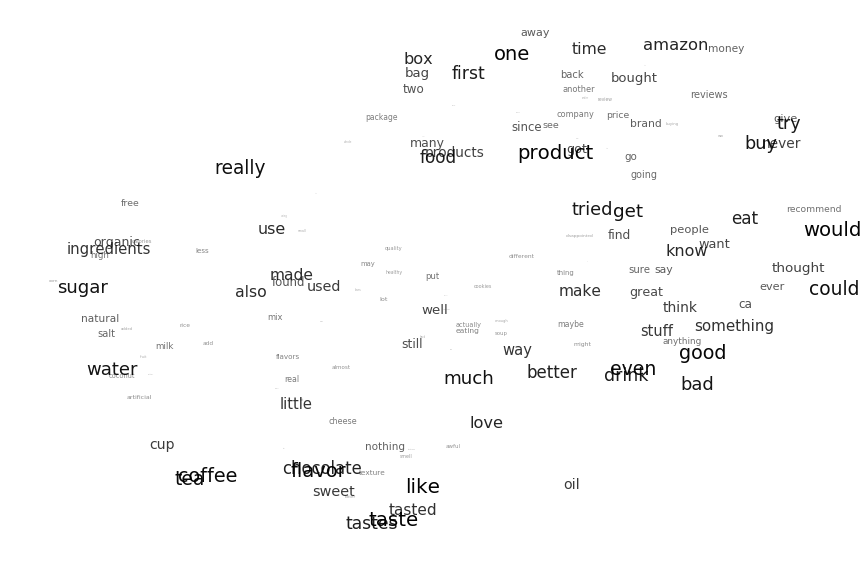

In [19]:
numWords = 150
targetWords = amazonRev1W2V.wv.index2word[:numWords]
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(amazonRev1W2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

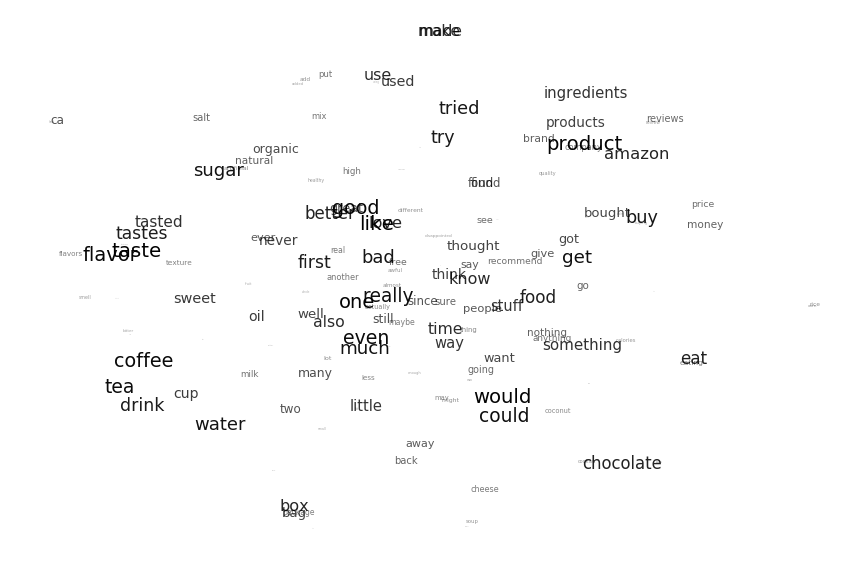

In [21]:
numWords = 150
targetWords = amazonRev1W2V.wv.index2word[:numWords]
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(amazonRev5W2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [420]:
apsDF = pandas.read_csv('APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

,copyrightYear,doi,abstract
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...
5,1951,10.1103/RevModPhys.23.311,A brief account is given of Dyson's proof of t...
6,1951,10.1103/RevModPhys.23.315,A systematics is given of all transitions for ...
7,1951,10.1103/RevModPhys.23.322,A systematics of the -transitions of even A nu...
8,1951,10.1103/RevModPhys.23.328,The available experiments on the absorption sp...
9,1952,10.1103/RevModPhys.24.108,The classical theory of the dynamics of viscou...


We will load these as documents into Word2Vec, but first we need to normalize and pick some tags

In [421]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [422]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: nltk.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = None))

In [423]:
taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

Now we can train a Doc2Vec model:

In [424]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [425]:
apsD2V.docvecs[1952]

array([ 0.73346984, -0.13325274, -0.06302337,  1.231637  , -1.2313054 ,
        0.4168763 ,  0.643582  , -0.4491875 , -1.6653268 , -0.80638176,
       -0.46863022,  1.7561258 , -0.17253369, -1.0576084 , -0.40470076,
       -1.2811414 , -0.31585503, -0.06562977, -0.9014394 , -0.7942742 ,
       -0.67845184,  1.4076664 ,  1.5227653 ,  1.3671234 ,  0.37329206,
        0.07577804,  0.07679775,  0.7170996 , -0.52424663,  1.4658972 ,
        0.88175094, -0.18718502,  0.9538433 , -0.14668554, -0.25636065,
       -0.636192  ,  0.3104981 , -0.45533904, -0.72953045, -0.23121905,
        0.33618367, -0.03105002, -0.3161761 , -0.02990106, -0.16141327,
       -0.4348071 ,  0.9703629 ,  1.3136618 ,  0.86023384,  1.5384426 ,
       -1.602061  , -0.6699388 , -1.3765596 , -0.64693314,  1.5389695 ,
       -0.6603671 , -0.9598561 , -0.0059782 ,  0.00950028,  0.5280418 ,
        0.4280107 , -0.17289518,  0.7612877 , -1.2143269 ,  0.37865853,
       -0.36944506,  1.3616266 , -0.5374898 ,  0.3683463 , -1.51

The words can still be accessed in the same way:

In [426]:
apsD2V['atom']

array([-0.64295995, -0.2500468 , -0.23467462, -0.21275388,  0.6337157 ,
        0.0293543 , -0.54436064, -0.99344474, -0.80255276, -0.50808734,
        0.19864476,  0.81891   ,  0.30804932, -0.88630295, -0.29641688,
        0.08500616,  0.5263936 ,  0.47387582,  0.22711095, -0.30012205,
       -0.3993079 ,  0.11863466,  0.6414395 ,  0.68267375, -0.4639147 ,
       -0.37130567, -0.64098144,  0.33128244,  0.177667  , -0.15493275,
        0.68911004,  0.3644851 ,  0.48302564, -0.05340426,  0.33482692,
       -0.6113427 ,  0.16273624,  0.61031157, -0.04309829,  0.3152845 ,
       -0.87016326,  0.21978936, -0.52189106, -0.7750558 ,  0.28699753,
        0.78917307, -0.42193592,  0.5581512 ,  0.70162475,  0.24896544,
       -0.89374864, -0.13331969, -0.9373966 , -0.2895503 ,  1.0128361 ,
       -0.6482408 , -0.2728868 ,  0.44462383,  0.9496401 ,  0.48471564,
       -0.07062526,  0.58945084, -0.5583193 , -0.7186154 , -0.22396271,
       -0.6973401 ,  0.03279728, -0.6148551 ,  0.26685983, -0.77

We can still use the ``most_similar`` command to perform simple semantic equations:

In [427]:
apsD2V.most_similar(positive = ['atom','electrons'], negative = ['electron'], topn = 1)

[('creating', 0.7902812361717224)]

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**! 

In [428]:
apsD2V.most_similar(positive = ['einstein','law'], negative = ['equation'], topn = 1)

[('herring', 0.9370138645172119)]

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra: 

In [429]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

array([[0.5817923]], dtype=float32)

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [430]:
apsD2V.docvecs.most_similar([ apsD2V['electron'] ], topn=5 )

[('10.1103/PhysRev.100.1646', 0.6768751740455627),
 ('10.1103/PhysRev.112.812', 0.6133017539978027),
 ('10.1103/PhysRev.109.1537', 0.6123897433280945),
 ('10.1103/PhysRev.84.621', 0.6019729375839233),
 ('10.1103/PhysRev.98.1584', 0.594475507736206)]

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:
<img src='../data/PhysRev.98.875.jpg'>

Now let's go the other way around and find words most similar to this document:

In [431]:
apsD2V.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ], topn=5) 

[('opposing', 0.7272302508354187),
 ('larmor', 0.7204463481903076),
 ('electric', 0.6952329874038696),
 ('demagnetizing', 0.6847338080406189),
 ('magnetocrystalline', 0.6798843741416931)]

We can even look for documents most like a query composed of multiple words:

In [432]:
apsD2V.docvecs.most_similar([ apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

[('10.1103/PhysRev.85.1012', 0.7946352958679199),
 ('10.1103/PhysRev.85.120', 0.7819576859474182),
 ('10.1103/PhysRev.113.156', 0.7710117101669312),
 ('10.1103/PhysRev.89.1165', 0.7620069980621338),
 ('10.1103/PhysRev.109.1193', 0.7531558275222778)]

Now let's plot some words and documents against one another with a heatmap:

In [433]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

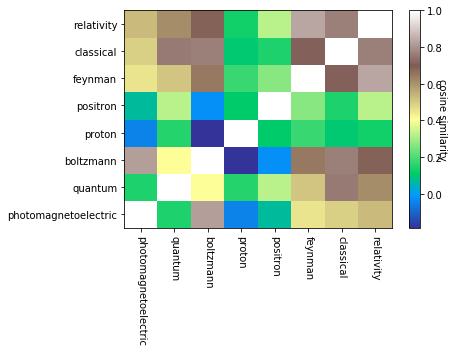

In [434]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [189]:
targetDocs = apsDF['doi'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

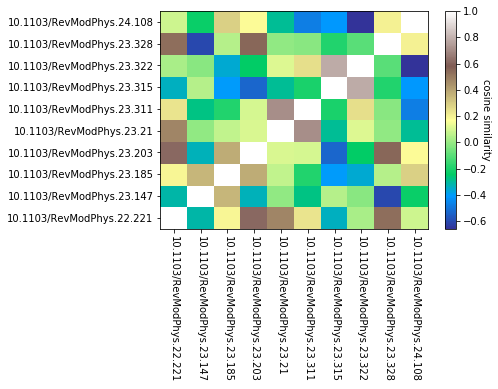

In [190]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [191]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

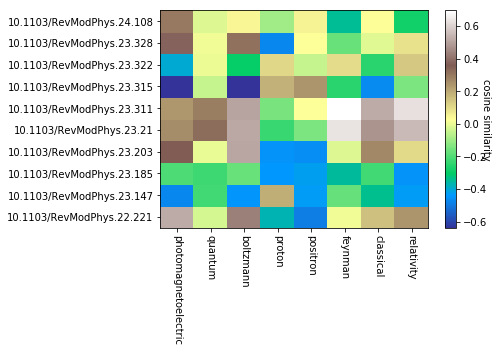

In [192]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [193]:
apsD2V.save('apsW2V')

We can later load it:

In [194]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that build a doc2vec model with your corpus. Interrogate document and word relationships in the resulting space. Construct a heatmap that plots the distances between a subset of your documents against each other, and against a set of informative words. Find distances between *every* document in your corpus and a word or query of interest. What do these doc-doc proximities reveal about your corpus? What do these word-doc proximities highlight? Demonstrate and document one reasonable way to select a defensible subset of query-relevant documents for subsequent analysis.

I will first create a set of keyword to which I will compare the documents (reviews) of my corpus. In order to make comparisons I will also have to tokenize and normalize words.

In [22]:
keywords = ['good', 'bad', 'taste', 'flavor', 'would', 'recommend', 'first', 'last']

In [23]:
amazonRev1DF['tokenized_words'] = amazonRev1DF['reviewText'].apply(lambda x: nltk.word_tokenize(x))
amazonRev1DF['normalized_words'] = amazonRev1DF['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = None))
amazonRev1DF

/Users/arielazar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/arielazar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,tokenized_sents,normalized_sents,tokenized_words,normalized_words
9,616719923X,"[0, 10]",1,"I love green tea, I love Kit Kats, but the two...","09 19, 2012",A33NXNZ79H5K51,"Jean M ""JM""",Not a fan,1348012800,"[[I, love, green, tea, ,, I, love, Kit, Kats, ...","[[love, green, tea, love, kit, kats, two, belo...","[I, love, green, tea, ,, I, love, Kit, Kats, ,...","[love, green, tea, love, kit, kats, two, belon..."
32,B00004S1C5,"[8, 11]",1,This product is no where near natural / organi...,"03 29, 2013",A14YSMLYLJEMET,Amazon Customer,Not natural/organic at all,1364515200,"[[This, product, is, no, where, near, natural,...","[[product, near, natural, wish, seen, reviews,...","[This, product, is, no, where, near, natural, ...","[product, near, natural, wish, seen, reviews, ..."
75,B0000CCZYY,"[1, 4]",1,"Licorice is my favorite candy, and it promotes...","04 5, 2013",A3OH4OZFZGEH75,Amazon Customer,Not soft at all. Basically same as cheap licor...,1365120000,"[[Licorice, is, my, favorite, candy, ,, and, i...","[[licorice, favorite, candy, promotes, good, d...","[Licorice, is, my, favorite, candy, ,, and, it...","[licorice, favorite, candy, promotes, good, di..."
82,B0000CCZYY,"[6, 11]",1,"This is an awesome product, natural, not a lot...","05 7, 2013",A2OUNVRPRWH0,"The Kittie ""Kittie""",Love this candy!,1367884800,"[[This, is, an, awesome, product, ,, natural, ...","[[awesome, product, natural, lot, ingredients,...","[This, is, an, awesome, product, ,, natural, ,...","[awesome, product, natural, lot, ingredients, ..."
85,B0000CD06J,"[0, 3]",1,"As soon as I had a couple of sips, my eczema s...","03 6, 2013",AX04H2SPKO02S,"J. Wang ""jyswang""",NOT gluten free,1362528000,"[[As, soon, as, I, had, a, couple, of, sips, ,...","[[soon, couple, sips, eczema, started, uncontr...","[As, soon, as, I, had, a, couple, of, sips, ,,...","[soon, couple, sips, eczema, started, uncontro..."
162,B0000CNU1X,"[0, 0]",1,unsure if I just got a bad batch or what...the...,"01 23, 2013",A1M9L949MA66I3,orlandodawg,Not good,1358899200,"[[unsure, if, I, just, got, a, bad, batch, or,...","[[unsure, got, bad, batch, flavor, bland, neve...","[unsure, if, I, just, got, a, bad, batch, or, ...","[unsure, got, bad, batch, flavor, bland, never..."
217,B0000DGDMO,"[1, 2]",1,Misleading. The reason this is cheaper than t...,"08 31, 2012",A30JPZ9TZ7I61U,"Christopher Barrett ""Evil Corgi""",Why is the picture showing the 24 pack?????,1346371200,"[[Misleading, .], [The, reason, this, is, chea...","[[misleading], [reason, cheaper, flavors, pack...","[Misleading, ., The, reason, this, is, cheaper...","[misleading, reason, cheaper, flavors, pack, w..."
265,B0000DID5R,"[6, 27]",1,"Well, I guess I'm the fly in this reviewer oin...","01 14, 2007",A34PAZQ73SL163,"Bernard Chapin ""Ora Et Labora!""",The Only One I Avoid.,1168732800,"[[Well, ,, I, guess, I, 'm, the, fly, in, this...","[[well, guess, fly, reviewer, ointment, dave, ...","[Well, ,, I, guess, I, 'm, the, fly, in, this,...","[well, guess, fly, reviewer, ointment, dave, h..."
270,B0000DID5R,"[3, 4]",1,"O.k., I'm going to offer a counterpoint to all...","11 11, 2012",A2MPW1R13SHA2S,Dangrenade,"Unpleasant Heat, and No Flavor",1352592000,"[[O.k., ,, I, 'm, going, to, offer, a, counter...","[[going, offer, counterpoint, positive, review...","[O.k., ,, I, 'm, going, to, offer, a, counterp...","[going, offer, counterpoint, positive, reviews..."
290,B0000DID5R,"[4, 24]",1,I just tried this sauce moments ago. Someone h...,"03 1, 2011",A3FHWQ3H3ZT2YE,"Patrice M. Christian ""Trixie.in.Dixie""",Maybe my taste buds are different.,1298937600,"[[I, just, tried, this, sauce, moments, ago, ....","[[tried, sauce, moments, ago], [someone, broug...","[I, just, tried, this, sauce, moments, ago, .,...","[tried, sauce, moments, ago, someone, brought,..."


In [24]:
amazonRev5DF['tokenized_words'] = amazonRev5DF['reviewText'].apply(lambda x: nltk.word_tokenize(x))
amazonRev5DF['normalized_words'] = amazonRev5DF['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = None))
amazonRev5DF

/Users/arielazar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/arielazar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,tokenized_sents,normalized_sents,tokenized_words,normalized_words
3,616719923X,"[0, 0]",5,"I had never had it before, was curious to see ...","05 20, 2013",A31QY5TASILE89,DebraDownSth,Unexpected flavor meld,1369008000,"[[I, had, never, had, it, before, ,, was, curi...","[[never, curious, see, like], [smooth, great, ...","[I, had, never, had, it, before, ,, was, curio...","[never, curious, see, like, smooth, great, sub..."
7,616719923X,"[2, 3]",5,Creamy white chocolate infused with Matcha gre...,"07 5, 2013",A3FIVHUOGMUMPK,greenlife,So Delicious!!,1372982400,"[[Creamy, white, chocolate, infused, with, Mat...","[[creamy, white, chocolate, infused, matcha, g...","[Creamy, white, chocolate, infused, with, Matc...","[creamy, white, chocolate, infused, matcha, gr..."
8,616719923X,"[0, 0]",5,After hearing mixed opinions about these Kit K...,"06 14, 2013",A27FSPAMTQF1J8,Japhyl,These are my favorite candies ever!,1371168000,"[[After, hearing, mixed, opinions, about, thes...","[[hearing, mixed, opinions, kit, kats, decided...","[After, hearing, mixed, opinions, about, these...","[hearing, mixed, opinions, kit, kats, decided,..."
10,616719923X,"[6, 8]",5,I ordered these in Summer so they of course ar...,"10 2, 2013",A220GN2X2R47JE,Jeremy,Amazing!,1380672000,"[[I, ordered, these, in, Summer, so, they, of,...","[[ordered, summer, course, arrived, melted, tr...","[I, ordered, these, in, Summer, so, they, of, ...","[ordered, summer, course, arrived, melted, tri..."
11,616719923X,"[2, 3]",5,These are definitely THE BEST candy bar out th...,"05 26, 2013",A3C5Z05IKSSFB9,"M. Magpoc ""maliasuperstar""",I wish I could find these in a store instead o...,1369526400,"[[These, are, definitely, THE, BEST, candy, ba...","[[definitely, best, candy, bar], [wish, able, ...","[These, are, definitely, THE, BEST, candy, bar...","[definitely, best, candy, bar, wish, able, fin..."
12,616719923X,"[0, 0]",5,Yes - this is one of the most expensive candie...,"07 6, 2013",AHA6G4IMEMAJR,"M. Zinn ""mczinn""",Thank goodness they are expensive,1373068800,"[[Yes, -, this, is, one, of, the, most, expens...","[[yes, one, expensive, candies, around, comes,...","[Yes, -, this, is, one, of, the, most, expensi...","[yes, one, expensive, candies, around, comes, ..."
13,616719923X,"[0, 0]",5,"I love the green tea kitkat, taste so good, no...","06 8, 2013",A1Q2E3W9PRG313,Sabrina,it is good,1370649600,"[[I, love, the, green, tea, kitkat, ,, taste, ...","[[love, green, tea, kitkat, taste, good, sweet...","[I, love, the, green, tea, kitkat, ,, taste, s...","[love, green, tea, kitkat, taste, good, sweet,..."
16,9742356831,"[0, 0]",5,This curry paste makes a delicious curry. I j...,"05 28, 2013",A23RYWDS884TUL,Another Freak,Delicious!,1369699200,"[[This, curry, paste, makes, a, delicious, cur...","[[curry, paste, makes, delicious, curry], [fri...","[This, curry, paste, makes, a, delicious, curr...","[curry, paste, makes, delicious, curry, fried,..."
17,9742356831,"[1, 2]",5,I've purchased different curries in the grocer...,"09 17, 2012",A945RBQWGZXCK,Cheryl,Great flavor,1347840000,"[[I, 've, purchased, different, curries, in, t...","[[purchased, different, curries, grocery, stor...","[I, 've, purchased, different, curries, in, th...","[purchased, different, curries, grocery, store..."
18,9742356831,"[2, 2]",5,I love ethnic foods and to cook them. I recent...,"08 3, 2013",A1TCSC0YWT82Q0,GinSing,OMG! What a treasure find!,1375488000,"[[I, love, ethnic, foods, and, to, cook, them,...","[[love, ethnic, foods, cook], [recently, purch...","[I, love, ethnic, foods, and, to, cook, them, ...","[love, ethnic, foods, cook, recently, purchase..."


I also had to create a unique id for each review in order to be able to identify them afterwards.

In [25]:
amazonRev5DF['uniqueID'] = amazonRev5DF['reviewerID'].astype(str) + amazonRev5DF['unixReviewTime'].astype(str)

/Users/arielazar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [26]:
amazonRev1DF['uniqueID'] = amazonRev1DF['reviewerID'].astype(str) + amazonRev1DF['unixReviewTime'].astype(str)
amazonRev1DF['uniqueID']

/Users/arielazar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


9         A33NXNZ79H5K511348012800
32        A14YSMLYLJEMET1364515200
75        A3OH4OZFZGEH751365120000
82          A2OUNVRPRWH01367884800
85         AX04H2SPKO02S1362528000
162       A1M9L949MA66I31358899200
217       A30JPZ9TZ7I61U1346371200
265       A34PAZQ73SL1631168732800
270       A2MPW1R13SHA2S1352592000
290       A3FHWQ3H3ZT2YE1298937600
320       A25VFHVGI4CFTP1335744000
339        AHRKNAVOFIQG01394755200
354       A3L61G6N7AT8N21388361600
355        AI0NMYA3LKXW11232323200
361       A29QXI9MWCVO7Q1288483200
383        A6KWQKOHSFYQC1379808000
470       A35Q0JH999NPN01361923200
495       A2GA64WZK8PKBC1356566400
504        A7WH560VVUXB21329004800
521        AD2QRU9ZXBQZ11393804800
539       A2WNN1DQVL4LH51333670400
544       A2F0ROXOUD88901366934400
565       A3CI9DSB6Z76JF1392508800
572       A2R62KGNIF8DX61355788800
597        AI20XOYZ8L6LJ1355356800
611       A2DB720I9XRX7K1193356800
613         A844QT2C8NQC1363564800
619       A2XKJ1KX6XUHYP1323648000
660       A1OXH6BF4L

In [27]:
taggedDocs1 = []
for index, row in amazonRev1DF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords1 = [s for s in keywords if s in row['normalized_words']]
    docKeywords1.append(row['uniqueID']) #This lets us extract individual documnets since doi's are unique
    taggedDocs1.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords1))
amazonRev1DF['TaggedReviews'] = taggedDocs1

/Users/arielazar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [28]:
taggedDocs5 = []
for index, row in amazonRev5DF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords5 = [s for s in keywords if s in row['normalized_words']]
    docKeywords5.append(row['uniqueID']) #This lets us extract individual documnets since doi's are unique
    taggedDocs5.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords5))
amazonRev5DF['TaggedReviews'] = taggedDocs5

/Users/arielazar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [51]:
amazonRev5DF.to_csv('amazonRev5DF.csv')
amazonRev1DF.to_csv('amazonRev1DF.csv')

I can now create a Doc2Vec model for each type of review in order to estimate distances between specific words and documents and therefore distances between documents with regards to a specidif word.

In [30]:
amazonRev1D2V = gensim.models.doc2vec.Doc2Vec(amazonRev1DF['TaggedReviews'], size = 100) #Limiting to 100 dimensions
amazonRev5D2V = gensim.models.doc2vec.Doc2Vec(amazonRev5DF['TaggedReviews'], size = 100) #Limiting to 100 dimensions

In [31]:
amazonRev1D2V.docvecs[1952]

array([-1.44154653e-01, -5.27904928e-02,  1.39810234e-01,  7.28615820e-02,
        9.29741636e-02,  5.42873964e-02,  1.46048903e-01, -1.41864821e-01,
        6.61028689e-03,  1.08347833e-01, -2.03778986e-02, -6.73220167e-03,
       -8.03600475e-02,  8.62790570e-02, -5.64883836e-02,  3.79160536e-03,
       -1.15229160e-01,  2.76977513e-02,  2.96101458e-02,  3.41008045e-02,
       -4.25110608e-02,  1.98343173e-01, -8.53242446e-03,  1.43601924e-01,
       -1.12235971e-01, -1.13572747e-01,  6.10507419e-03, -4.34884839e-02,
       -7.52002299e-02,  1.10004477e-01, -2.18043514e-02,  9.67059359e-02,
        2.69874334e-02,  1.03579927e-02, -3.61195244e-02, -1.42384738e-01,
       -4.46230769e-02, -5.93880564e-02,  1.81173176e-01, -4.96142358e-02,
       -1.61356509e-01, -5.36050983e-02,  1.25570288e-02,  1.26216620e-01,
       -1.27851903e-01,  2.45110523e-02, -8.10444281e-02,  5.80507480e-02,
       -4.20890003e-02, -1.31168328e-02,  2.48326045e-02, -1.29341250e-04,
       -5.16787432e-02, -

I can show, for example the 5 documents that are 'closest' to the word `good` in both types of reviews. 

In [32]:
amazonRev1D2V.docvecs.most_similar([ amazonRev1D2V['good'] ], topn=5 )

[('A22VNXHU6IZ5MT1331769600', 0.9437639117240906),
 ('A1R1BFJCMWX0Y31313971200', 0.9416506886482239),
 ('AZAKCIFE27RAA1308787200', 0.9371153712272644),
 ('A1T43UUK4EDHC21379721600', 0.9248603582382202),
 ('A3B9QZNGAOZSXH1358640000', 0.9150854349136353)]

In [35]:
amazonRev5D2V.docvecs.most_similar([ amazonRev1D2V['good'] ], topn=5 )

[('AFCXZGQDQB8EK1389052800', 0.7587423324584961),
 ('A2LXC5ZHHP0WXP1332374400', 0.7576904296875),
 ('A108PBHPOJ7X4Z1403913600', 0.7506402134895325),
 ('A3T0CQMWAOIPK31355875200', 0.7494800090789795),
 ('ADEZOPMPKK1461236124800', 0.7471585869789124)]

I can also show the five words that are closer to a specific document (in this case, the top two documents closer to the word `good` in each corpus). It is interesting to see that for the 5-star reviews, documents that are closer to the word `good` are closer to it than the documents that are closer to the same word in the 5-star reviews. 

In [38]:
amazonRev1D2V.most_similar( [ amazonRev1D2V.docvecs['A22VNXHU6IZ5MT1331769600'] ], topn=5)

[('think', 0.9614860415458679),
 ('something', 0.9461454153060913),
 ('argue', 0.9455932378768921),
 ('good', 0.9416506886482239),
 ('thought', 0.9362425208091736)]

In [50]:
amazonRev5D2V.most_similar( [ amazonRev5D2V.docvecs['AFCXZGQDQB8EK1389052800'] ], topn=5)

[('coffeecake', 0.8593560457229614),
 ('cleansed', 0.8490613698959351),
 ('lozenge', 0.8468270897865295),
 ('andthis', 0.8436360359191895),
 ('productive', 0.8399413824081421)]

It is also possible to see the distance of specific documents to a combination of words. 

In [40]:
amazonRev1D2V.docvecs.most_similar([ amazonRev1D2V['terrible']+amazonRev1D2V['coffee']], topn=5 )

[('A1R6DKN9YQ2YU11327536000', 0.9681601524353027),
 ('A2V5R832QCSOMX1290643200', 0.9628283977508545),
 ('AI0PLL5DQAHRG1364342400', 0.960732638835907),
 ('AOYSWD91I82C21389052800', 0.9567286372184753),
 ('A1R9QOPV6HVEKF1212710400', 0.952499508857727)]

Review A1R6DKN9YQ2YU11327536000: `Obviously everyone's tastes are different, so just because I didn't like this doesn't mean you won't. I tried this hot and was only able to get through a couple sips. I tasted no lemon whatsoever, and the ginger was totally overpowering and bitter. As another reviewer mentioned, this is not a lemony golden color in your cup, as shown on the package...it's a dark swampy color. Like coffee with a lot of milk in it. I guess I was hoping for a light gingery lemon flavor that would be soothing, but this was far from it. I'm always on the hunt for new teas other warm beverages, so I'm glad I got to try this. Unfortunately it just wasn't for me.`

In [52]:
amazonRev5D2V.docvecs.most_similar([ amazonRev5D2V['terrible']+amazonRev5D2V['coffee']], topn=5 )

[('A23LF95HUEIGUR1362960000', 0.6358020305633545),
 ('A3H0814AB2IWUA1299369600', 0.598336935043335),
 ('AM004PHO6F3FZ1279065600', 0.5936683416366577),
 ('A2O49UZ3R0IM111348531200', 0.593308687210083),
 ('A4PI4DZJSVF6Q1311552000', 0.57705157995224)]

Review A23LF95HUEIGUR1362960000: `I drink coffee!  I grind my own and use an Aerobie  press to make espresso and use that to make American style with hazelnut. I use the Taster's Choice for a quick cup thru the day or for the bedside cup at night. As I said, I drink coffee. Taster's Choice Instant  is unequivocally the best instant.  The fairly recent switch by Nestl&eacute; to the "house blend" was a little disappointing at first, but the taste seems to have adjusted back to an instant full bodied rich instant taste. It'll certainly do when you can't brew`

In order to visualize the word to word and doc to word distances, I can creat a heatmap. Firt I show the distances between my keywords for each corpus, and then the distances between the keywords and the first 40 reviews of each corpus. In general, it is striking that the keywords are really far from each other in the 5-star reviews, while they are closer in the 1-star reviews.

In [43]:
heatmapMatrix1 = []
for tagOuter in keywords:
    column1 = []
    tagVec1 = amazonRev1D2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column1.append(sklearn.metrics.pairwise.cosine_similarity(tagVec1, amazonRev1D2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix1.append(column1)
heatmapMatrix1 = np.array(heatmapMatrix1)

In [44]:
heatmapMatrix5 = []
for tagOuter in keywords:
    column5 = []
    tagVec5 = amazonRev5D2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column5.append(sklearn.metrics.pairwise.cosine_similarity(tagVec5, amazonRev5D2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix5.append(column5)
heatmapMatrix5 = np.array(heatmapMatrix5)

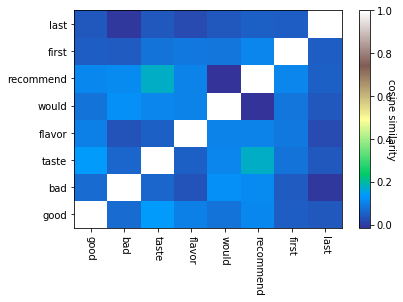

In [45]:
fig5, ax5 = plt.subplots()
hmap5 = ax5.pcolor(heatmapMatrix5, cmap='terrain')
cbar5 = plt.colorbar(hmap5)

cbar5.set_label('cosine similarity', rotation=270)
a5 = ax5.set_xticks(np.arange(heatmapMatrix5.shape[1]) + 0.5, minor=False)
a5 = ax5.set_yticks(np.arange(heatmapMatrix5.shape[0]) + 0.5, minor=False)

a5 = ax5.set_xticklabels(keywords, minor=False, rotation=270)
a5 = ax5.set_yticklabels(keywords, minor=False)

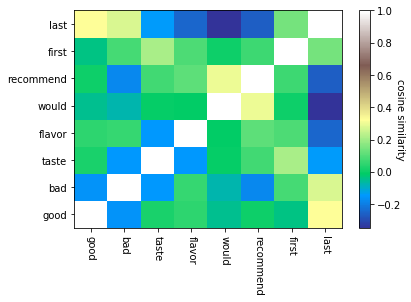

In [46]:
fig1, ax1 = plt.subplots()
hmap1 = ax1.pcolor(heatmapMatrix1, cmap='terrain')
cbar1 = plt.colorbar(hmap1)

cbar1.set_label('cosine similarity', rotation=270)
a1 = ax1.set_xticks(np.arange(heatmapMatrix1.shape[1]) + 0.5, minor=False)
a1 = ax1.set_yticks(np.arange(heatmapMatrix1.shape[0]) + 0.5, minor=False)

a1 = ax1.set_xticklabels(keywords, minor=False, rotation=270)
a1 = ax1.set_yticklabels(keywords, minor=False)

Regarding word to documents distnaces, there is not much of a stroy here when comparing both corpus. There doesn't seem to be a sistematic difference between the documents (reviews) of each corpus in terms of their distances to each keyword. 

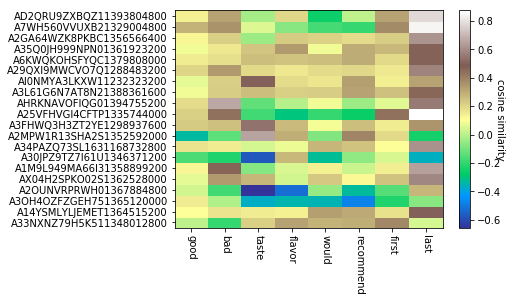

In [48]:
targetDocs1 = amazonRev1DF['uniqueID'][:20]

heatmapMatrixC1 = []

for tagOuter in targetDocs1:
    column1 = []
    tagVec1 = amazonRev1D2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column1.append(sklearn.metrics.pairwise.cosine_similarity(tagVec1, amazonRev1D2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC1.append(column1)
heatmapMatrixC1 = np.array(heatmapMatrixC1)

fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC1, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC1.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC1.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs1, minor=False)

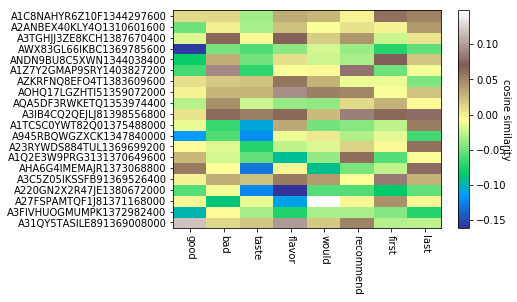

In [49]:
targetDocs5 = amazonRev5DF['uniqueID'][:20]

heatmapMatrixC5 = []

for tagOuter in targetDocs5:
    column5 = []
    tagVec5 = amazonRev5D2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column5.append(sklearn.metrics.pairwise.cosine_similarity(tagVec5, amazonRev5D2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC5.append(column5)
heatmapMatrixC5 = np.array(heatmapMatrixC5)

fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC5, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC5.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC5.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs5, minor=False)

# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles. 

In [491]:
nytimes_model = gensim.models.KeyedVectors.load_word2vec_format('../data/nytimes_cbow.reduced.txt')

First we can visualize with dimension reduction

In [475]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.343139, -0.117117, -0.50773 , ..., -0.995696,  0.921299,
         0.943769],
       [-0.362909, -0.263528,  0.032661, ..., -0.043032, -0.178965,
         0.353556],
       [-0.70167 , -0.344525, -0.320714, ...,  0.009001,  0.11055 ,
         0.751077],
       ...,
       [-2.391626, -1.90143 ,  1.031182, ...,  2.947464,  1.01588 ,
         2.00033 ],
       [-2.432387, -1.161415,  1.060064, ...,  4.402381,  0.500471,
         1.644596],
       [ 0.981931,  0.628094, -0.747547, ...,  1.612927,  1.148063,
         1.063776]], dtype=float32)

In [476]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

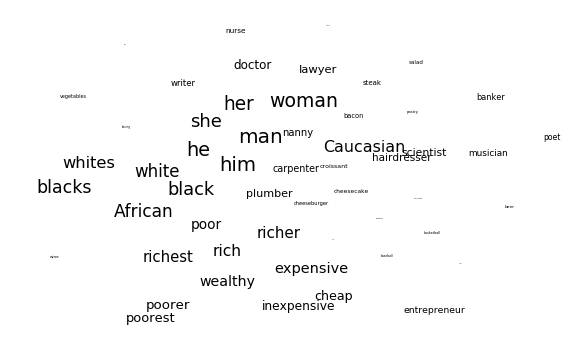

In [477]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  20 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [478]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [479]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [480]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [481]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [482]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

Define some useful functions for plotting.

In [483]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

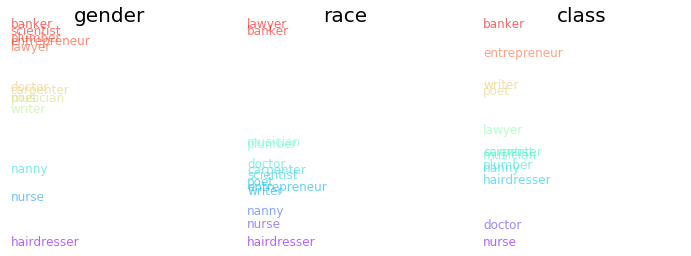

In [484]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

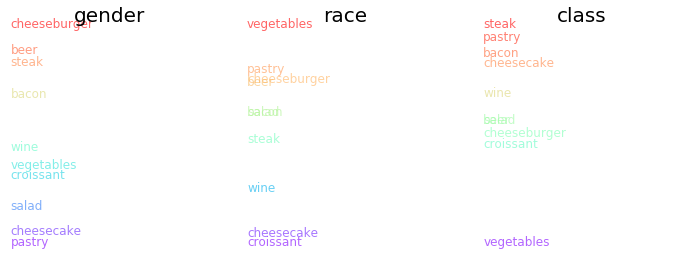

In [485]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

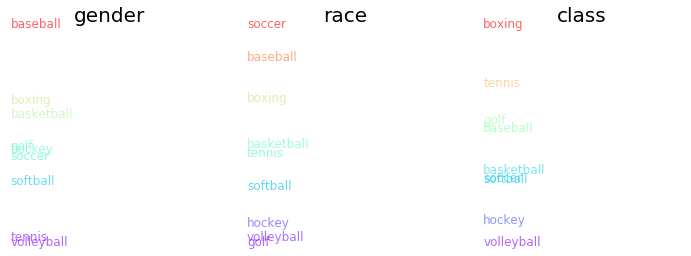

In [486]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that identify semantic dimensions of interest from your data (e.g., gender: man-woman) and project words onto these dimensions. Plot the array of relevant words along each semantic dimension. Which words are most different. Which dimensions are most different? On which dimension are your words most different? Print three short textual examples from the corpus that illustrate the association you have explored.

<span style="color:red">***Stretch***: Project documents from your corpus along a dimension of interest. Sample relevant documents from your corpus with this functionality and explain your rationale? Calculate the cosine of the angle between two dimensions (encoded as vectors) of interest. What does this suggest about the relationship between them within your corpus? 

<span style="color:red">***Stretch***: Create 90% bootstrap confidence intervals around your word projections onto a given dimension. Which words are *significantly* different on your semantic dimension of interest?

I created two dimensions of words: quality and price. And i projected different products to these two dimensions. The dimension of quality refers to the words `'good','excellent','wonderful', 'love', 'tasty'` on one side, and `'bad', 'awful', 'terrible','disgusting', 'horrible', 'hate'` on the other. The dimension prices refers to `'cheap','inexpensive','reasonable','bargain'` on one extreme and `'expensive','overpriced','pricey'` on the other.

The products i projected in these two dimensions are: `"coffee","tea","chocolate","sweet","drink","sugar","oil","salt","water", "milk","cheese"`.

Figures below show how these producst group together along these dimensions. In order to better understand this, I show the reviews that are closer to two words that group along one dimension. 

It appears like for both dimensions in both corpus, the products tend to move along them. There are no outliers in terms of words that are alone into one side of the dimension. 

In [494]:
#words to create dimensions
tnytTargetWords = ['good','excellent','wonderful', 'love', 'tasty', 'bad', 'awful', 'terrible','disgusting', 'horrible', 'hate', 'recommend', 'never','ever']
#words we will be mapping
tnytTargetWords += ["coffee","tea","chocolate","sweet","drink","sugar","oil","salt","water", "milk","cheese","price", "cheap","expensive"] 


wordsSubMatrix1 = []
for word in tnytTargetWords:
    wordsSubMatrix1.append(amazonRev1W2V[word])
wordsSubMatrix1 = np.array(wordsSubMatrix1)

wordsSubMatrix5 = []
for word in tnytTargetWords:
    wordsSubMatrix5.append(amazonRev5W2V[word])
wordsSubMatrix5 = np.array(wordsSubMatrix5)

wordsSubMatrix1
wordsSubMatrix5

array([[-1.2660439 , -0.7665725 , -1.6470104 , ..., -0.67608315,
        -1.7169847 ,  2.05244   ],
       [-0.10291965, -0.8993131 , -0.8248925 , ...,  0.03215067,
        -3.4902704 ,  0.06042543],
       [-0.35797802, -0.60168684, -1.2322078 , ...,  0.32692266,
        -3.0393124 ,  1.0459208 ],
       ...,
       [ 2.0685303 ,  0.17548347,  3.1997015 , ..., -0.99658644,
        -1.0764699 ,  0.33164707],
       [ 0.35732442, -1.2120711 ,  0.24628246, ..., -0.752275  ,
        -0.1150727 ,  0.45997214],
       [ 1.5246966 , -1.3938973 , -0.38325736, ..., -1.0957669 ,
        -0.10645051,  1.0627522 ]], dtype=float32)

In [495]:
pcaWordsAmazonRev1 = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix1)
reducedPCA_dataAmazonRev1 = pcaWordsAmazonRev1.transform(wordsSubMatrix1)
#T-SNE is theoretically better, but you should experiment
tsneWordsAmazonRev1 = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataAmazonRev1)

In [496]:
pcaWordsAmazonRev5 = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix5)
reducedPCA_dataAmazonRev5 = pcaWordsAmazonRev5.transform(wordsSubMatrix5)
#T-SNE is theoretically better, but you should experiment
tsneWordsAmazonRev5 = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataAmazonRev5)

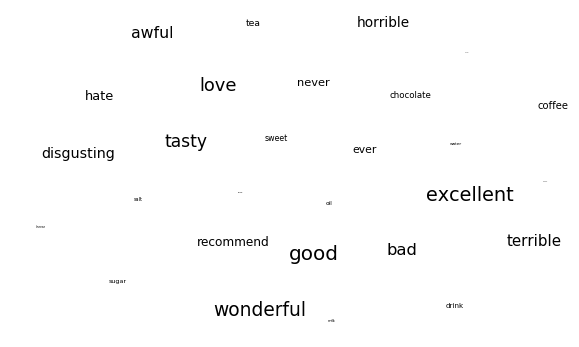

In [502]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsAmazonRev5[:, 0], tsneWordsAmazonRev5[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsAmazonRev5[:, 0][i],tsneWordsAmazonRev5[:, 1][i]), size =  20 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

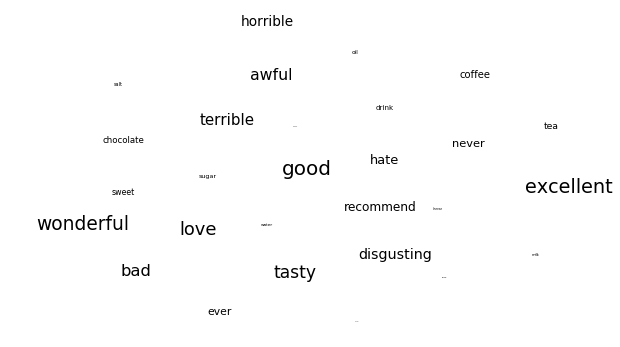

In [501]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsAmazonRev1[:, 0], tsneWordsAmazonRev1[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsAmazonRev1[:, 0][i],tsneWordsAmazonRev1[:, 1][i]), size =  20 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

In [503]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [580]:
Quality1 = dimension(amazonRev1W2V, ['good','excellent','wonderful', 'love', 'tasty'], ['bad', 'awful', 'terrible','disgusting', 'horrible', 'hate'])
Quality5 = dimension(amazonRev5W2V, ['good','excellent','wonderful', 'love', 'tasty'], ['bad', 'awful', 'terrible','disgusting', 'horrible', 'hate'])
Price1 = dimension(amazonRev1W2V, ['cheap','inexpensive','reasonable','bargain'],['expensive','overpriced','pricey'])
Price5 = dimension(amazonRev5W2V, ['cheap','inexpensive','reasonable','bargain'],['expensive','overpriced','pricey'])

In [581]:
Products = ["coffee","tea","chocolate","sweet","drink","sugar","oil","salt","water", "milk","cheese"] 

In [582]:
def makeDF1(model, word_list):
    q = []
    p = []
    for word in word_list:
        q.append(sklearn.metrics.pairwise.cosine_similarity(amazonRev1W2V[word].reshape(1,-1), Quality1.reshape(1,-1))[0][0])
        p.append(sklearn.metrics.pairwise.cosine_similarity(amazonRev1W2V[word].reshape(1,-1), Price1.reshape(1,-1))[0][0])
    df1 = pandas.DataFrame({'quality': q, 'price': p}, index = word_list)
    return df1

In [583]:
def makeDF5(model, word_list):
    q = []
    p = []
    for word in word_list:
        q.append(sklearn.metrics.pairwise.cosine_similarity(amazonRev5W2V[word].reshape(1,-1), Quality5.reshape(1,-1))[0][0])
        p.append(sklearn.metrics.pairwise.cosine_similarity(amazonRev5W2V[word].reshape(1,-1), Price5.reshape(1,-1))[0][0])
    df5 = pandas.DataFrame({'quality': q, 'price': p}, index = word_list)
    return df5

In [584]:
productsdf1 = makeDF1(amazonRev1W2V, Products) 
productsdf5 = makeDF5(amazonRev5W2V, Products) 

In [585]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

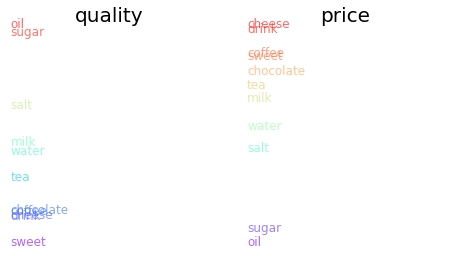

In [586]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, productsdf1, 'quality')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, productsdf1, 'price')

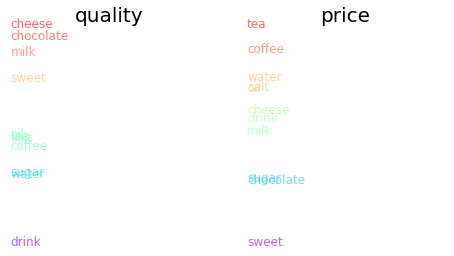

In [587]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, productsdf5, 'quality')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, productsdf5, 'price')

In [570]:
amazonRev1D2V.docvecs.most_similar([ amazonRev1D2V['oil']+amazonRev1D2V['sugar']], topn=5 )

[('A2ND0L3LI06XCS1363910400', 0.968715488910675),
 ('A1WXJ1I42UOQ2V1162944000', 0.9054543375968933),
 ('ASWQHCBXTTMKR1238803200', 0.9034537672996521),
 ('A75W6T9I2S8BA1385856000', 0.8989149332046509),
 ('A2WZNM833CJH821369526400', 0.8939142823219299)]

As someone who used to purchase Peanut Butter & Co.'s peanut butter regularly several years ago, I was disappointed to find out that they changed the recipe for the worse. The ingredients listed are incorrect, as peanuts and salt are not the only ingredients.When I got the jars, I saw that they read "new and improved formula" and "now easier to spread." The "new and improved formula" means they added sugar and oil, so the ingredients in the item listing are incorrect, since peanuts and salt are not the only ingredients. The ingredient list on the jar is, and I quote, "Peanuts, evaporated cane juice, palm fruit oil, salt." I was hoping to avoid added sugar and oil when shopping for a natural peanut butter. Although they did not add high fructose corn syrup or hydrogenized oil, this is still unacceptable considering the item listing says it only contains peanuts and salt."Easier to spread" means it feels and tastes less like the natural peanut butter this product once was. It now has the consistency of unnatural, low quality peanut butters like Jiff and Peter Pan.What's worse is that I could not return the peanut butter since it is a food item and is nonreturnable as per Amazon's guidelines. The ingredient list was misleading, and I was charged for a product that I did not want. I gave the jars to a local homeless shelter hoping some good would come from this.I bought Laura Scudder's peanut butter recently, and I'm glad to see they still make a delicious, natural peanut butter without any additives. Just be wary if you order that peanut butter online, because they are glass jars and may break during shipping.

In [571]:
amazonRev1D2V.docvecs.most_similar([ amazonRev1D2V['chocolate']+amazonRev1D2V['coffee']], topn=5 )

[('A3RR2UWBJ8YVSQ1359763200', 0.9618515968322754),
 ('A1DTCJV6KOMJOA1298851200', 0.9603062272071838),
 ('A36MP37DITBU6F1357257600', 0.9542288184165955),
 ('A19FRW264WZTGP1327968000', 0.9521538019180298),
 ('A3EXIZWHSNVNME1313366400', 0.9490017890930176)]

I love most of the Kashi bars.  My favorite is the dark mocha almond.  I decided I'd try something different, so I purchased these layered dark chocolate coconut ones.  Firstly, there is no chocolate flavor in the bar that I can detect.  So sad!  I love chocolate and really, you can't taste any in this bar.  Secondly, the frosting and/or topping of the bar tastes really weird.  Can't tell if it tastes like dates or what!  No coconut flavor can be had in this bar, either.  In fact, the entire bar doesn't really taste like much of anything.  A real disappointment.

In [574]:
amazonRev5D2V.docvecs.most_similar([ amazonRev5D2V['cheese']+amazonRev5D2V['chocolate']], topn=5 )

[('A3F8JQ5J29GWUV1370736000', 0.5145186185836792),
 ('A2B2ENQHZ9TL8A1296604800', 0.5112622976303101),
 ('A2FRFAQCWZJT3Q1295827200', 0.4961188733577728),
 ('A2LEIANN1UZTHP1367366400', 0.48445314168930054),
 ('A2BJ81NT43LKSM1351555200', 0.48379117250442505)]

If you want to make mochas, or drizzle a really yummy dark chocolate sauce on any kind of dessert, then this is for you. It's fantastic.

My daughter and I LOVE macaroni and cheese. Its been a long time since I've been able to enjoy it from the box.  I used to like Annie's but it was never cheesy enough.This is though. :)Mix the cheese and milk together in a bowl first. I use less milk than called for, otherwise its runny.This is animal rennet free, which is why I buy it!  I was so happy to find this on Amazon. great price, too.

In [576]:
amazonRev5D2V.docvecs.most_similar([ amazonRev5D2V['drink']+amazonRev5D2V['sugar']], topn=5 )

[('A3A15L96IYUO6V1210464000', 0.6241133809089661),
 ('A19SDJ2TSSL8HI1366502400', 0.6160730123519897),
 ('A1GQAKL9CGQLP11376956800', 0.5588579177856445),
 ('A34IGZ989XN4ZH1287446400', 0.5465002059936523),
 ('A1OZBI4KLZXWKF1297382400', 0.5452165007591248)]

IZZE Grapefruit is great for those who think regular grapefruit juice is too acidic or overpowering. This blend is just perfect -- a bit of sparkling water with the grapefruit juice and not much else. This allows for a refreshing taste, but make sure it is cold. Given that I'm not much of a carbonated soda drinker, this isn't a replacement for a can of Sprite. Rather, it's just another beverage in my arsenal to replace my other daily juices if I don't want to go crazy on the calories.

I have type 2 diabetes and it's very hard to find anything sweet that doesn't cause a spike in my blood glucose. Lots of sugar free things have additives like maltodextrine, dextrose, sorbitol, etc that also cause blood glucose spikes. Even if you're not diabetic, fluctuations in blood glucose can also cause fluctuations in your appetite and make it hard to stay on track if you're trying to diet.I saw this in the store, read the ingredients and found that there's nothing in there that's a red flag to me so I bought a bottle. First I tried it just plain in a bottle of water. I liked it well enough but after using it to make a slushy drink and adding just a few drops of Mio orange, I was in heaven. I could drink that every day. It's also really good with Mio blueberry lemonade added (sounds awful I know but I liked it).I thought I'd have to do without smoothies (fruit = sugar, milk = carbs) but I find if I add a half a banana (or sometimes I just add banana flavoring since a large banana has over 20 grams of carbs/sugar), 2-3 tablespoons of heavy cream (which has less than 1 gram of carbs per tablespoon and a little goes a long way) the Dasani Pineapple Coconut drops, water and ice and blend it up and it's so GOOD! It kind of reminds me a little of a blended Mai Tai sort of drink.Okay, I admit, it's not really a true smoothie or a shake but it's creamy and it satisfies when I'm craving something sweet and it doesn't spike my blood glucose.I'm definitely going to stock up on this because it tastes good to me and it's one of the few sweet things I can eat.One last thing is I love that it's so portable and I can take it with me to use away from home. Especially since I'm not too fond of soda.